# Carry Factor Analysis

This notebook walks through a carry factor analysis, for both time series and cross-sectional strategies, in digital assets.

We will construct various carry factors and compare their performance across a range of statistical tests and financial evaluation criteria.

Carry is a ubiquitous factor investing strategy and is also a good way to capture yield in cryptoassets when markets are not trending.

In [87]:
# uncomment to install factorlab
# pip install factorlab

In [88]:
import pandas as pd
import numpy as np

# from cryptodatapy.extract.datarequest import DataRequest
# from cryptodatapy.extract.getdata import GetData
# from cryptodatapy.transform.clean import CleanData

from factorlab.feature_engineering.factors.carry import Carry
from factorlab.feature_engineering.transform import Transform
from factorlab.feature_analysis.factor_analysis import Factor
from factorlab.feature_analysis.param_grid_search import *
from factorlab.feature_analysis.time_series_analysis import linear_reg, rolling_window
from factorlab.feature_analysis.performance import Performance
from factorlab.data_viz.data_viz import plot_series, plot_bar, plot_table

# Data 

To collect the necessary data for the analysis (perpetual futures, funding rates, spot prices, and aggregate spot prices), we use **CryptoDataPy**, an open source python library that makes it easy to build high quality data pipelines for the analysis of cryptoassets.

It will allow us to pull data from various exchanges and data vendors with ease, clean and stich the data to create the longest possible price and total return series.

To install **CryptoDataPy**:
`pip install cryptodatapy`

In [89]:
# uncomment to install cryptodatapy
# pip install cryptodatapy

## Collect Data

- Funding rates and perptual futures OHLC prices from **Binance** futures exchange (2019-present)
- OHLC spot prices from **Binance** spot exchange (2017-2019)
- OHLC spot prices from **Cryptocompare** (2010-2017)

Install **CryptoDataPy** and uncomment to get updated price data.

### Tickers

#### Binance

In [90]:
# # get all Binance perp futures tickers
# data_req = DataRequest(source='ccxt')
# perp_tickers = GetData(data_req).get_meta(method='get_markets_info', exch='binanceusdm', as_list=True)

In [91]:
# # get Binance spot tickers
# data_req = DataRequest(source='ccxt')
# spot_tickers = GetData(data_req).get_meta(method='get_markets_info', exch='binance', as_list=True)

In [92]:
# # find intersecting tickers
# binance_tickers = [ticker for ticker in perp_tickers if ticker in spot_tickers]

In [93]:
# # number of tickers
# len(binance_tickers)

#### Cryptocompare

In [94]:
# # get cryptocompare tickers
# data_req = DataRequest(source='cryptocompare')
# cc_tickers = GetData(data_req).get_meta(method='get_assets_info', as_list=True)

In [95]:
# # keep only USDT ticker
# bin_tickers = []
# for ticker in binance_tickers:
#     if '/' in ticker and ticker.split('/')[1] == 'USDT':
#         bin_tickers.append(ticker.split('/')[0])

In [96]:
# usdt tickers
# usdt_tickers = [ticker.split('/')[0] for ticker in binance_tickers if '/'in ticker and ticker.split('/')[1] == 'USDT']

In [97]:
# # intersecting tickers
# tickers = [ticker for ticker in usdt_tickers if ticker in cc_tickers]

### OHLC Prices

#### Binance - Perpetual Futures

In [98]:
# # pull daily OHLC and funding rates for perp futures on Binance USDM exchange
# data_req = DataRequest(source='ccxt',
#                        tickers=tickers, 
#                        fields=['open', 'high', 'low', 'close', 'volume', 'funding_rate'], 
#                        mkt_type='perpetual_future', 
#                        freq='d')

In [99]:
# df1 = GetData(data_req).get_series()

In [100]:
# df1.head()

In [112]:
# pull csv perp futures prices
df = pd.read_csv('../src/factorlab/datasets/data/binance_perp_fut_prices.csv', 
                  index_col=['date', 'ticker'],
                  parse_dates=True
                 )

In [113]:
df.head()

,,open,high,low,close,volume,funding_rate
date,ticker,,,,,,
2019-09-08,BTC,10000.00,10412.65,10000.00,10391.63,3096.291,NaN
2019-09-09,BTC,10316.62,10475.54,10077.22,10307.00,14824.373,NaN
2019-09-10,BTC,10307.00,10382.97,9940.87,10102.02,9068.955,NaN
2019-09-11,BTC,10094.27,10293.11,9884.31,10159.55,10897.922,0.0003
2019-09-12,BTC,10163.06,10450.13,10042.12,10415.13,15609.634,0.0003


### Preprocess Data

#### Clean data

Now, that we have all of our raw data, we can clean our data using the *CleanData* class in **CryptoDataPy** and chaining the following methods:

- *Filter outliers* to remove outliers using interquantile range and a threshold.
- *Repair outliers* and missing values using the IQR expected value.
- *Filter average trading value* to reduce the trading universe to include only asset trading a minimum of daily dollar volume (1 mil USD).
- *Remove missing values gaps* to drop the values of any series where sequential missing values are above some threshodl value.

In [114]:
# drop tickers with nobs < ts_obs
obs = df.iloc[:, :-1].groupby(level=1).count().min(axis=1)
drop_tickers_list = obs[obs < 30].index.to_list()
df = df.drop(drop_tickers_list, level=1, axis=0)

# drop tickers with nobs < cs_obs
obs = df.iloc[:, :-1].groupby(level=0).count().min(axis=1)
idx_start = obs[obs > 3].index[0]
df = df.unstack()[df.unstack().index > idx_start].stack()

# sort cols
df = df[['open', 'high', 'low', 'close', 'volume', 'funding_rate']]
# rename close
df = df.rename(columns={'close': 'spot', 'funding_rate': 'rate'})

In [115]:
# number of assets
len(list(df.index.droplevel(0).unique()))

228

## Target and Factor Construction

### Create Targets
Create log return and forward return target variables.

In [116]:
# compute total returns
ret_df = Transform(df.spot).returns().copy()
ret_df = pd.concat([ret_df, df.rate.fillna(0)], join='outer', axis=1).sort_index()
ret_df['tr'] = ret_df.spot.subtract(ret_df.rate, axis=0)

In [117]:
# compute forward returns
fwd_spot_ret = Transform(df.spot).returns(lags=1, forward=True).rename(columns={'spot':'fwd_ret_1'})
fwd_spot_ret['fwd_ret_5'] = Transform(df.spot).returns(lags=5, forward=True).spot
fwd_spot_ret['fwd_ret_7'] = Transform(df.spot).returns(lags=7, forward=True).spot
fwd_spot_ret['fwd_ret_10'] = Transform(df.spot).returns(lags=10, forward=True).spot
fwd_spot_ret['fwd_ret_14'] = Transform(df.spot).returns(lags=14, forward=True).spot
fwd_spot_ret['fwd_ret_20'] = Transform(df.spot).returns(lags=20, forward=True).spot
fwd_spot_ret['fwd_ret_30'] = Transform(df.spot).returns(lags=30, forward=True).spot
fwd_spot_ret['fwd_ret_60'] = Transform(df.spot).returns(lags=60, forward=True).spot
fwd_spot_ret['fwd_ret_90'] = Transform(df.spot).returns(lags=90, forward=True).spot
fwd_spot_ret['fwd_ret_180'] = Transform(df.spot).returns(lags=180, forward=True).spot
fwd_spot_ret['fwd_ret_365'] = Transform(df.spot).returns(lags=365, forward=True).spot

In [118]:
# normalize fwd rets
fwd_ret_norm = Transform(fwd_spot_ret).normalize_ts(window_type='expanding')

In [119]:
# compute fwd relative returns
fwd_rel_ret = fwd_spot_ret.copy()
for col in fwd_rel_ret.columns:
    fwd_rel_ret[col] = fwd_spot_ret[col] - fwd_spot_ret[col].groupby('date').mean()

In [120]:
# mkt returns
mkt_ret = Transform(df).returns(market=True, mkt_field='spot')

### Compute Carry Factors

In [140]:
# carry factor
carry_obj = Carry(df)
carry_df = carry_obj.carry
# median
carry_df = carry_df.join(carry_obj.smooth(window_size=2, central_tendency='median'))
carry_df = carry_df.join(carry_obj.smooth(window_size=3, central_tendency='median'))
carry_df = carry_df.join(carry_obj.smooth(window_size=4, central_tendency='median'))
carry_df = carry_df.join(carry_obj.smooth(window_size=5, central_tendency='median'))
carry_df = carry_df.join(carry_obj.smooth(window_size=6, central_tendency='median'))
carry_df = carry_df.join(carry_obj.smooth(window_size=7, central_tendency='median'))
# # smw
# carry_df = carry_df.join(carry_obj.smooth(window_size=2, central_tendency='mean'))
# carry_df = carry_df.join(carry_obj.smooth(window_size=3, central_tendency='mean'))
# carry_df = carry_df.join(carry_obj.smooth(window_size=4, central_tendency='mean'))
# carry_df = carry_df.join(carry_obj.smooth(window_size=5, central_tendency='mean'))
# carry_df = carry_df.join(carry_obj.smooth(window_size=6, central_tendency='mean'))
# carry_df = carry_df.join(carry_obj.smooth(window_size=7, central_tendency='mean'))
# ewm
carry_df = carry_df.join(carry_obj.smooth(window_size=2, window_type='ewm', central_tendency='mean'))
carry_df = carry_df.join(carry_obj.smooth(window_size=3, window_type='ewm', central_tendency='mean'))
carry_df = carry_df.join(carry_obj.smooth(window_size=4, window_type='ewm', central_tendency='mean'))
carry_df = carry_df.join(carry_obj.smooth(window_size=5, window_type='ewm', central_tendency='mean'))
carry_df = carry_df.join(carry_obj.smooth(window_size=6, window_type='ewm', central_tendency='mean'))
carry_df = carry_df.join(carry_obj.smooth(window_size=7, window_type='ewm', central_tendency='mean'))
# carry to std
carry_df = carry_df.join(carry_obj.carry_risk_ratio(norm_method='std'))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(norm_method='std', norm_window_size=60))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(norm_method='std', norm_window_size=90))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=2, sm_window_type='ewm', sm_central_tendency='mean', norm_method='std'))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=3, sm_window_type='ewm', sm_central_tendency='mean', norm_method='std'))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=2, sm_window_type='ewm', sm_central_tendency='mean', norm_method='std', norm_window_size=60))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=3, sm_window_type='ewm', sm_central_tendency='mean', norm_method='std', norm_window_size=60))
# carry to iqr
carry_df = carry_df.join(carry_obj.carry_risk_ratio(norm_method='iqr'))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(norm_method='iqr', norm_window_size=60))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(norm_method='iqr', norm_window_size=90))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=2, sm_central_tendency='median', norm_method='iqr'))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=3, sm_central_tendency='median', norm_method='iqr'))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=2, sm_central_tendency='median', norm_method='iqr', norm_window_size=60))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=3, sm_central_tendency='median', norm_method='iqr', norm_window_size=60))
# carry to mad
carry_df = carry_df.join(carry_obj.carry_risk_ratio(norm_method='mad'))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(norm_method='mad', norm_window_size=60))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(norm_method='mad', norm_window_size=90))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=2, sm_central_tendency='median', norm_method='mad'))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=3, sm_central_tendency='median', norm_method='mad'))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=2, sm_central_tendency='median', norm_method='mad', norm_window_size=60))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=3, sm_central_tendency='median', norm_method='mad', norm_window_size=60))
# carry to range
carry_df = carry_df.join(carry_obj.carry_risk_ratio(norm_method='range'))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(norm_method='range', norm_window_size=60))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(norm_method='range', norm_window_size=90))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=2, sm_central_tendency='median', norm_method='range'))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=3, sm_central_tendency='median', norm_method='range'))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=2, sm_central_tendency='median', norm_method='range', norm_window_size=60))
carry_df = carry_df.join(carry_obj.carry_risk_ratio(smoothing=True, sm_window_size=3, sm_central_tendency='median', norm_method='range', norm_window_size=60))

In [141]:
carry_df.columns

Index(['carry', 'carry_median_2', 'carry_median_3', 'carry_median_4',
       'carry_median_5', 'carry_median_6', 'carry_median_7', 'carry_mean_2',
       'carry_mean_3', 'carry_mean_4', 'carry_mean_5', 'carry_mean_6',
       'carry_mean_7', 'carry_to_std_30', 'carry_to_std_60', 'carry_to_std_90',
       'carry_mean_2_to_std_30', 'carry_mean_3_to_std_30',
       'carry_mean_2_to_std_60', 'carry_mean_3_to_std_60', 'carry_to_iqr_30',
       'carry_to_iqr_60', 'carry_to_iqr_90', 'carry_median_2_to_iqr_30',
       'carry_median_3_to_iqr_30', 'carry_median_2_to_iqr_60',
       'carry_median_3_to_iqr_60', 'carry_to_mad_30', 'carry_to_mad_60',
       'carry_to_mad_90', 'carry_median_2_to_mad_30',
       'carry_median_3_to_mad_30', 'carry_median_2_to_mad_60',
       'carry_median_3_to_mad_60', 'carry_to_range_30', 'carry_to_range_60',
       'carry_to_range_90', 'carry_median_2_to_range_30',
       'carry_median_3_to_range_30', 'carry_median_2_to_range_60',
       'carry_median_3_to_range_60'],

In [142]:
carry_df.describe()

,carry,carry_median_2,carry_median_3,carry_median_4,carry_median_5,carry_median_6,carry_median_7,carry_mean_2,carry_mean_3,carry_mean_4,...,carry_median_3_to_mad_30,carry_median_2_to_mad_60,carry_median_3_to_mad_60,carry_to_range_30,carry_to_range_60,carry_to_range_90,carry_median_2_to_range_30,carry_median_3_to_range_30,carry_median_2_to_range_60,carry_median_3_to_range_60
count,165409.000000,164993.000000,164293.000000,163375.000000,162267.000000,160990.000000,159572.000000,160487.000000,160487.000000,160487.000000,...,1.464780e+05,1.346180e+05,1.344320e+05,1.515060e+05,1.452690e+05,1.394690e+05,1.515060e+05,1.512920e+05,1.446720e+05,1.444740e+05
mean,-0.000338,-0.000339,-0.000349,-0.000363,-0.000375,-0.000386,-0.000394,-0.000392,-0.000392,-0.000392,...,3.794049e+10,1.317335e+11,7.706313e+10,6.303251e+10,7.157577e+10,1.370321e+11,6.303251e+10,3.857600e+10,4.429548e+10,7.280665e+10
std,0.002451,0.002229,0.002083,0.001898,0.001768,0.001668,0.001610,0.001585,0.001541,0.001488,...,4.050547e+13,3.021680e+13,1.559222e+13,2.474166e+13,1.496919e+13,2.116875e+13,2.474166e+13,1.349186e+13,7.876702e+12,1.497579e+13
min,-0.020591,-0.018344,-0.017019,-0.015786,-0.014873,-0.014873,-0.014427,-0.014411,-0.014152,-0.013196,...,-1.001602e+16,-2.462149e+12,-2.109525e+12,-5.008012e+15,-2.153058e+12,-3.976946e+08,-5.008012e+15,-2.504006e+15,-1.845251e+12,-1.581311e+12
25%,-0.000494,-0.000496,-0.000497,-0.000498,-0.000498,-0.000499,-0.000498,-0.000500,-0.000503,-0.000506,...,-6.264420e+00,-4.711575e+00,-4.690122e+00,-2.121353e+00,-1.242964e+00,-9.821313e-01,-2.114400e+00,-2.109929e+00,-1.236174e+00,-1.229537e+00
50%,-0.000331,-0.000325,-0.000324,-0.000322,-0.000321,-0.000321,-0.000320,-0.000318,-0.000315,-0.000312,...,-2.442034e+00,-1.813698e+00,-1.812030e+00,-1.039978e+00,-5.446495e-01,-3.925903e-01,-1.042208e+00,-1.040662e+00,-5.460485e-01,-5.467530e-01
75%,-0.000168,-0.000139,-0.000137,-0.000134,-0.000136,-0.000136,-0.000138,-0.000131,-0.000126,-0.000120,...,-4.356114e-01,-3.057082e-01,-3.054445e-01,-1.814313e-01,-9.304787e-02,-6.598686e-02,-1.819849e-01,-1.825895e-01,-9.275280e-02,-9.275200e-02
max,0.200747,0.138883,0.115419,0.089158,0.071718,0.066439,0.063671,0.063172,0.062579,0.060546,...,1.047459e+16,1.047459e+16,5.237296e+15,5.237296e+15,5.237296e+15,5.237296e+15,5.237296e+15,2.618648e+15,2.484987e+15,4.969973e+15


# Factor Analysis

## Statistical Tests

Statistical tests allow us to assess the strenght of the relationship between the alpha factors (features) and foward returns (target variable).

### Historical Correlation and Association Measures
Correlation measures, e.g. spearman rank correlation (aka information coefficient), and association measures, e.g. mutul information, allow us to evaluate the predictive relationship between an alpha factors and forward returns. 
- The `strategy` parameter in the `filter` method can be set to either "ts" or "cs" for either time series or cross-sectional strategies.

In [143]:
# compute stats for time series strategies
Factor(carry_df, fwd_ret_norm.fwd_ret_7, strategy='ts', factor_bins=5, ret_bins=3, window_type='fixed').filter(rank_on='spearman_r')

,spearman_r
carry_mean_7,0.07
carry_mean_6,0.06
carry_mean_4,0.06
carry_mean_3,0.06
carry,0.06
carry_mean_5,0.06
carry_mean_2,0.06
carry_median_7,0.06
carry_median_2,0.06
carry_median_3,0.05


In [144]:
# compute stats for cross-sectional strategies 
Factor(carry_df, fwd_ret_norm.fwd_ret_7, strategy='cs', factor_bins=5, ret_bins=3, window_type='fixed').filter(rank_on='spearman_r')

,spearman_r
carry,0.04
carry_median_2,0.03
carry_median_3,0.03
carry_mean_7,0.03
carry_mean_6,0.03
carry_median_7,0.02
carry_median_4,0.02
carry_mean_2,0.02
carry_mean_5,0.02
carry_mean_3,0.02


In [145]:
# compute stats for dual strategies 
Factor(carry_df, fwd_ret_norm.fwd_ret_7, strategy='dual', factor_bins=5, ret_bins=3, window_type='fixed').filter(rank_on='spearman_r')

,spearman_r
carry_mean_7,0.04
carry_mean_6,0.03
carry,0.03
carry_mean_4,0.03
carry_mean_5,0.03
carry_median_2,0.03
carry_mean_3,0.03
carry_mean_2,0.03
carry_median_7,0.03
carry_median_3,0.03


### Rolling Window IC
The information coefficient (or spearman rank correlation) can be computed over a rolling window to allow us to see the change in predictive relationship between the factors and forward returns.

In [146]:
# IC rolling window for time series strategy
ic_ts_df = Factor(carry_df, ret_df.spot, strategy='ts_ls', window_size=365).ic(factor='carry')

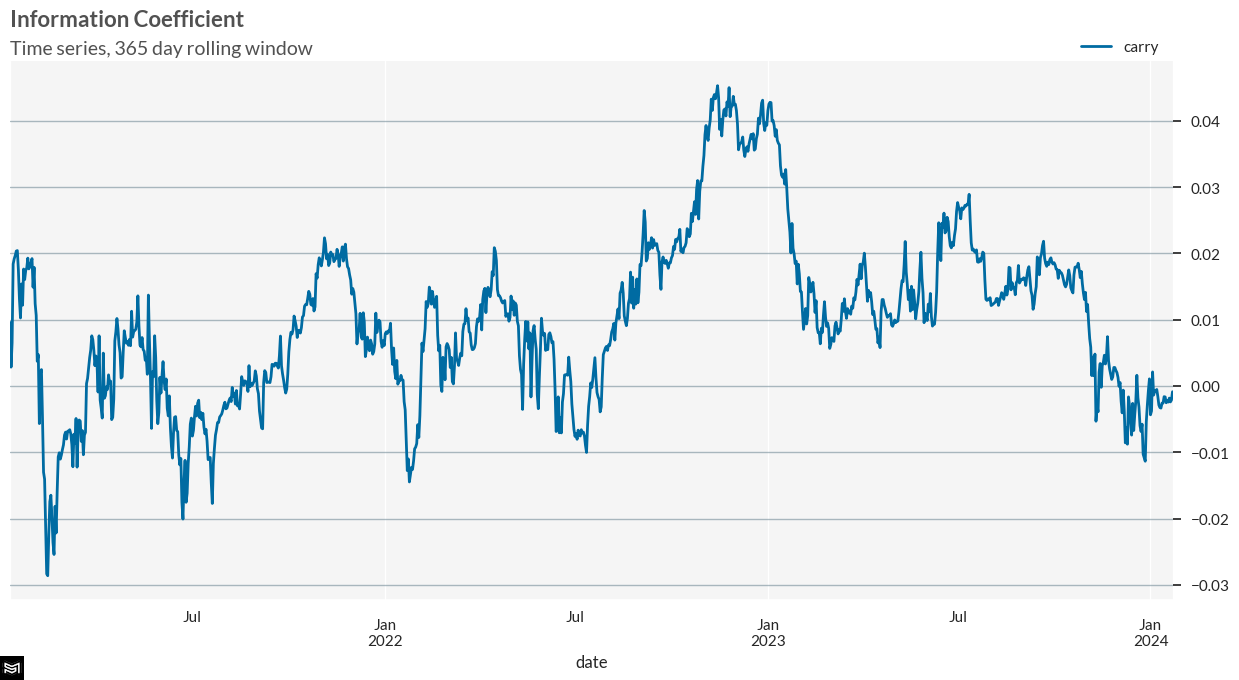

In [147]:
plot_series(ic_ts_df.dropna(), 
            title='Information Coefficient',
            subtitle='Time series, 365 day rolling window',
            add_logo=True
           )

In [148]:
# IC rolling window for cross sectional strategy
ic_cs_df = Factor(carry_df, ret_df.spot, strategy='cs_ls', window_size=365).ic(factor='carry')

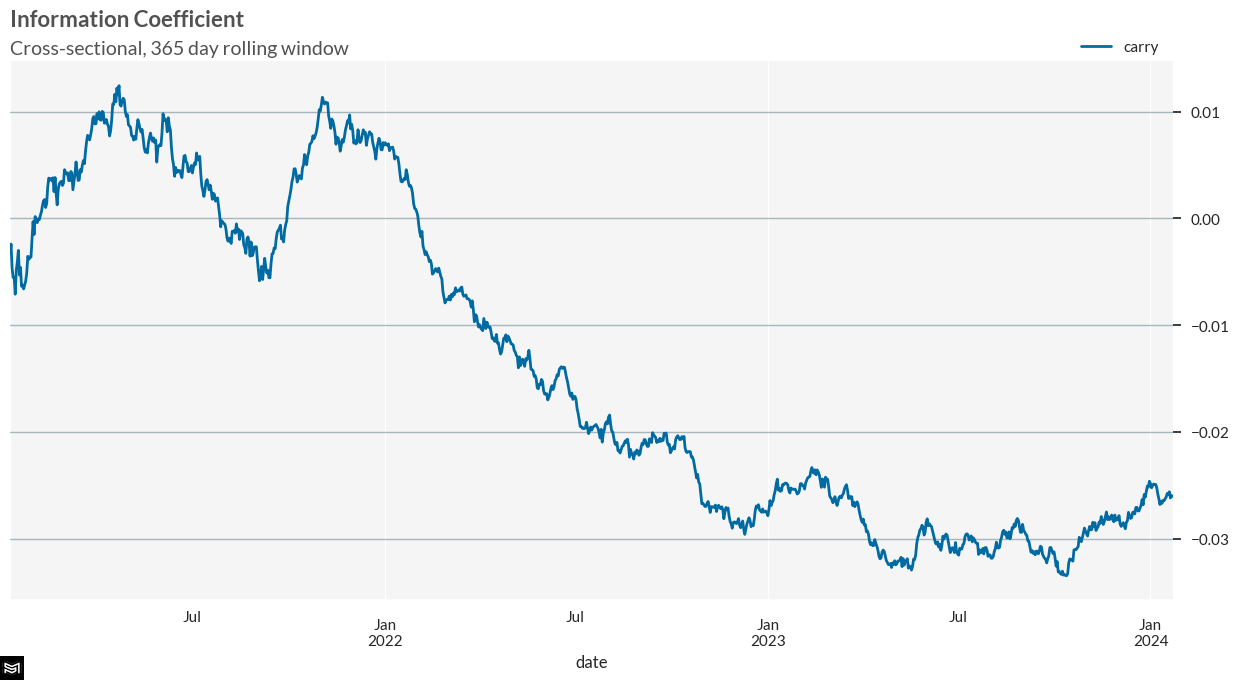

In [149]:
plot_series(ic_cs_df.dropna(), 
            title='Information Coefficient',
            subtitle='Cross-sectional, 365 day rolling window',
            add_logo=True
           )

In [150]:
# IC rolling window for cross sectional strategy
ic_dual_df = Factor(carry_df, ret_df.spot, strategy='dual_ls', window_size=365).ic(factor='carry')

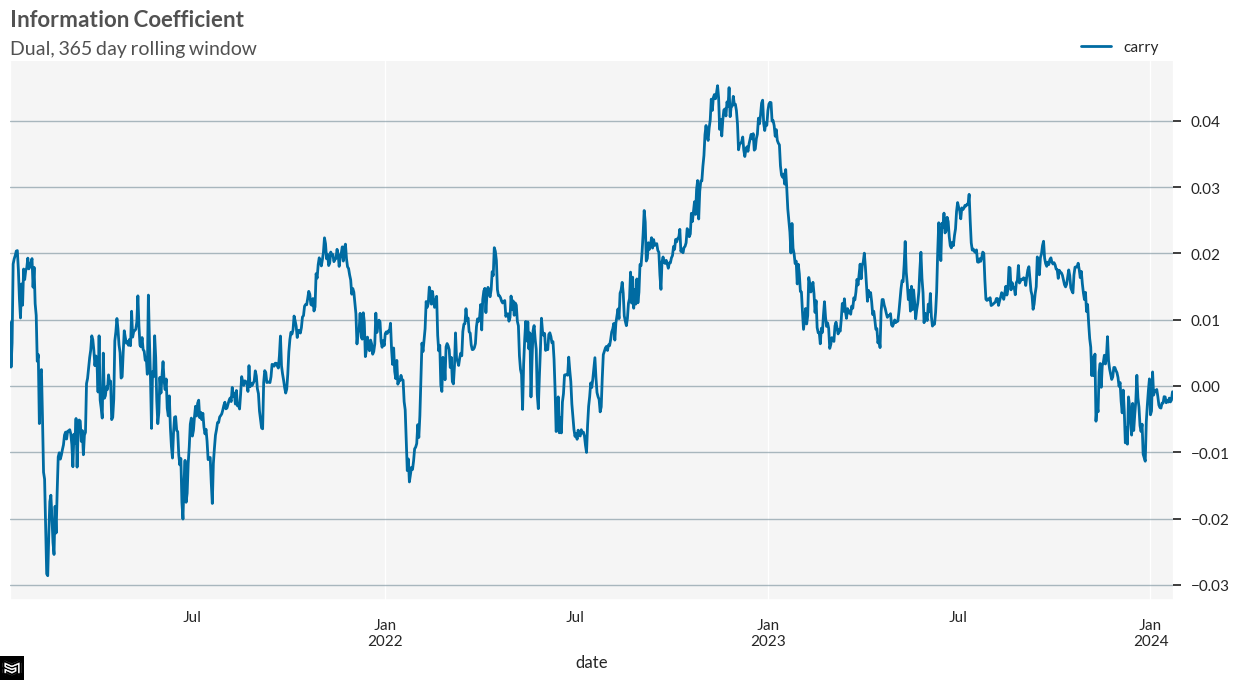

In [151]:
plot_series(ic_dual_df.dropna(), 
            title='Information Coefficient',
            subtitle='Dual, 365 day rolling window',
            add_logo=True
           )

### Regression
We can regress factors on forward returns (normalized) to assess their economic and statistical significance.

In [152]:
# pooled regression for time series 
Factor(carry_df.dropna(), fwd_ret_norm.fwd_ret_7, strategy='ts').regression(method='pooled')

,beta,pval,rsq
carry_median_7,12.047023,0.0,0.000554
carry_mean_2,11.62278,0.0,0.000497
carry_median_6,11.193356,0.0,0.00051
carry_mean_3,10.19621,0.000002,0.000358
carry_mean_7,9.737277,0.000043,0.000235
carry_median_5,8.808815,0.000004,0.000353
carry_mean_4,7.472453,0.000627,0.000178
carry_median_4,6.855992,0.000231,0.000239
carry_mean_5,4.532338,0.040668,0.00006
carry_mean_6,4.28638,0.057355,0.000049


In [153]:
# cross sectional fama-macbeth
Factor(carry_df.dropna(), fwd_ret_norm.fwd_ret_7, strategy='cs').regression(method='fama-macbeth')

,beta,std_error,t-stat
carry_to_range_90,0.0393,0.0266,1.4795
carry_median_2_to_range_60,0.0298,0.0207,1.4344
carry_median_3_to_range_60,0.0295,0.0209,1.4113
carry_median_3_to_range_30,0.0268,0.0117,2.2926
carry_to_range_60,0.0253,0.0202,1.2526
carry_median_2_to_range_30,0.0245,0.0115,2.1280
carry_to_range_30,0.0233,0.0115,2.0287
carry_to_mad_90,0.0091,0.0059,1.5541
carry_median_3_to_iqr_60,0.0062,0.0079,0.7930
carry_median_2_to_iqr_60,0.0049,0.0079,0.6208


## Factor Returns
Factor returns (net of t-cost estimate) provide a measure of factor performance. 
- The `strategy` parameter in the factor returns function allows you to explore factor returns for both long-only '_l' and long/short strategies '_ls', for either time series 'ts' or cross-sectional 'cs' implementations. 
- The `tails` parameter allows you to keep only factor values in the tails of the distribution and ignore the rest. Often, the most predictive information is contained in the tails.

### Time Series

In [154]:
# ts trend returns
carry_ts_ret = Factor(carry_df, ret_df.tr, strategy='ts_ls').returns(signal_type='disc_signal')

In [155]:
carry_ts_perf_table = Performance(carry_ts_ret, mkt_ret=mkt_ret, ret_type='log').table(metrics='all', rank_on='Sharpe ratio').iloc[:20]

In [156]:
carry_ts_perf_table

,Cumulative return,Annual return,Annual volatility,Skewness,Kurtosis,Max drawdown,VaR,Tail ratio,Sharpe ratio,Sortino ratio,Calmar ratio,Omega ratio,Stability,Annual alpha,Alpha p-val,Beta,Beta p-val
carry_median_3_to_range_60,1.32,0.23,0.44,0.84,20.96,-0.38,-0.03,0.96,0.47,0.61,0.62,1.09,0.83,0.23,0.33,-0.05,0.00
carry_median_2_to_range_60,1.19,0.21,0.44,0.66,18.58,-0.37,-0.03,1.02,0.44,0.57,0.57,1.08,0.82,0.21,0.37,-0.04,0.00
carry_to_range_60,0.61,0.13,0.43,-0.08,12.16,-0.48,-0.03,0.99,0.28,0.35,0.26,1.05,0.62,0.13,0.58,-0.01,0.34
carry_to_mad_90,0.34,0.07,0.37,-1.84,33.15,-0.54,-0.03,1.11,0.19,0.21,0.14,1.04,0.27,0.07,0.70,0.08,0.00
carry_median_3_to_mad_60,0.27,0.06,0.37,-0.46,11.86,-0.45,-0.03,1.00,0.16,0.19,0.13,1.03,0.28,0.06,0.75,0.07,0.00
carry_to_range_90,0.26,0.06,0.44,0.02,8.02,-0.59,-0.04,1.00,0.13,0.16,0.10,1.02,0.29,0.06,0.80,0.01,0.20
carry_median_2_to_mad_60,0.20,0.05,0.37,-0.43,12.56,-0.45,-0.03,0.98,0.13,0.14,0.10,1.02,0.17,0.05,0.81,0.08,0.00
carry_median_3_to_iqr_30,0.13,0.03,0.49,-2.83,43.51,-0.62,-0.03,1.00,0.06,0.06,0.05,1.01,0.00,0.02,0.91,0.26,0.00
carry_median_2_to_range_30,0.09,0.02,0.41,-0.93,18.57,-0.59,-0.03,1.02,0.05,0.06,0.04,1.01,0.02,0.02,0.92,0.07,0.00
carry_median_3_to_range_30,0.07,0.02,0.41,-0.79,18.37,-0.59,-0.03,1.03,0.04,0.05,0.03,1.01,0.04,0.02,0.93,0.05,0.00


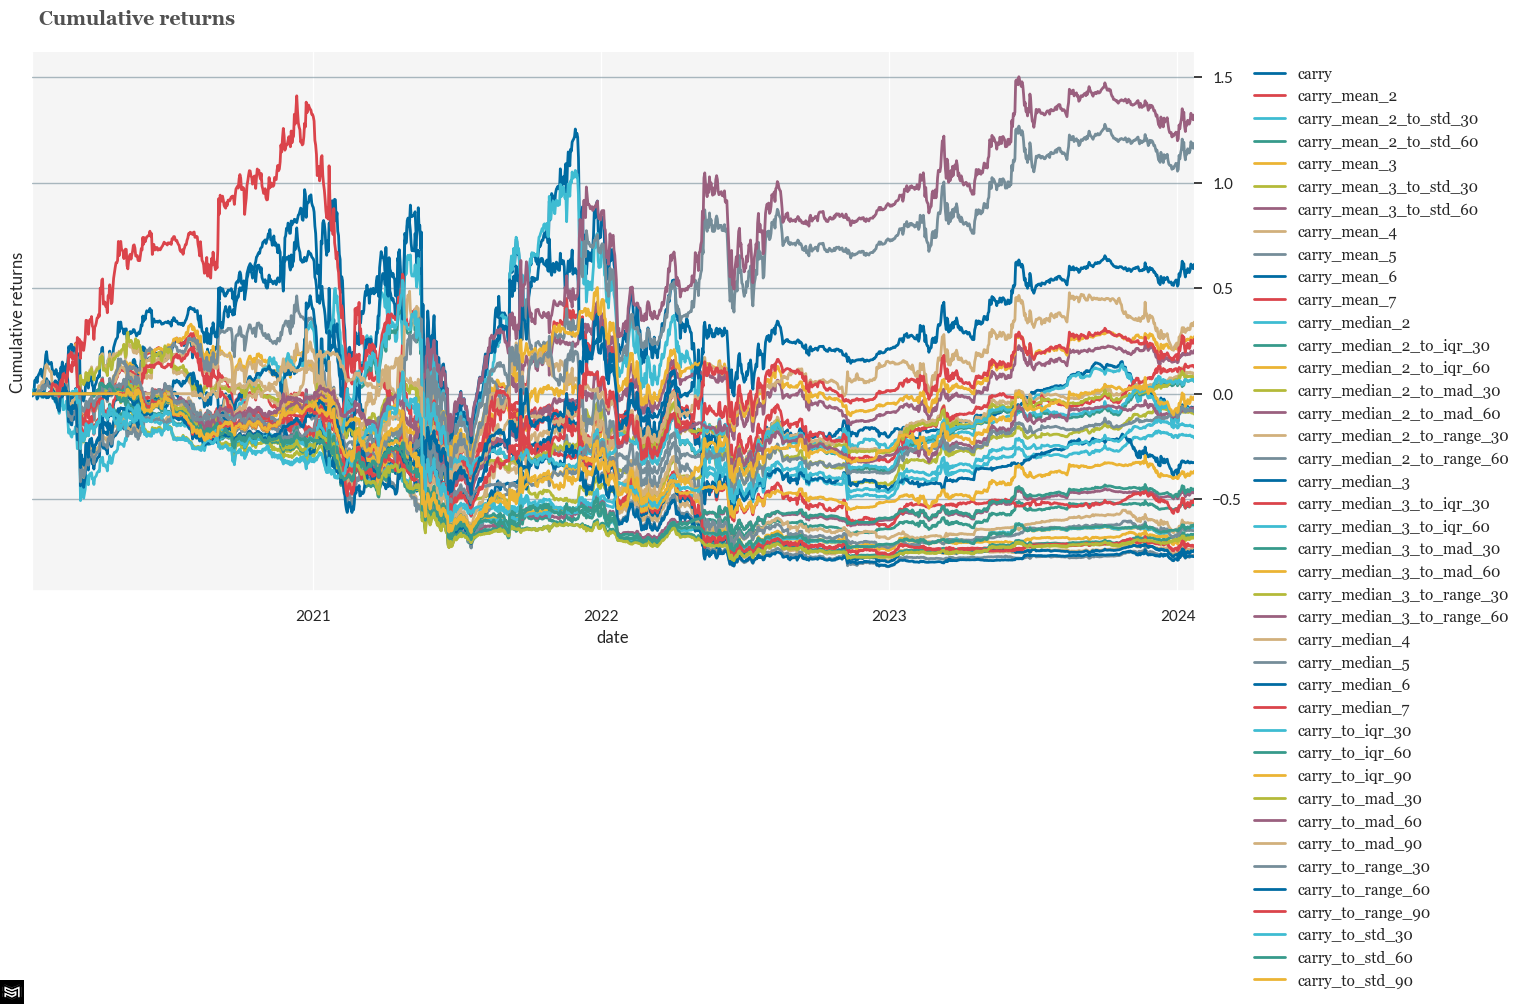

In [157]:
Performance(carry_ts_ret, mkt_ret=mkt_ret, ret_type='log', window_type='expanding').plot_metric()

In [158]:
carry_ts_perf_table.mean()

Cumulative return     0.1910
Annual return         0.0350
Annual volatility     0.4665
Skewness             -1.3715
Kurtosis             25.8220
Max drawdown         -0.5745
VaR                  -0.0330
Tail ratio            0.9935
Sharpe ratio          0.0800
Sortino ratio         0.1015
Calmar ratio          0.0875
Omega ratio           1.0150
Stability             0.1905
Annual alpha          0.0320
Alpha p-val           0.8095
Beta                  0.1385
Beta p-val            0.0270
dtype: float64

### Cross-Sectional
Cross-sectional strategies sorts assets in the cross-section into equal-weighted portfolios based on their factor values. Weights for each portfolio can be scaled by on the portfolios quantile (e.g. 1 for the assets in the top quintile of factor values, 0.5 for the 2nd quintile, 0 for the third, etc), or traditional portfolio sorts where top vs. bottom quantiles are given weights of 1 and -1.

In [204]:
# cs carry returns
carry_cs_ret = Factor(carry_df, ret_df.tr, strategy='cs_ls', factor_bins=5).returns(signal_type='signal_quantiles', tails='two', rebal_freq='monday', t_cost=0.002, weighting='ew')

In [205]:
carry_cs_perf_table = Performance(carry_cs_ret, mkt_ret=mkt_ret, ret_type='log').table(metrics='all', rank_on='Sharpe ratio').iloc[:20]

In [200]:
carry_cs_perf_table

,Cumulative return,Annual return,Annual volatility,Skewness,Kurtosis,Max drawdown,VaR,Tail ratio,Sharpe ratio,Sortino ratio,Calmar ratio,Omega ratio,Stability,Annual alpha,Alpha p-val,Beta,Beta p-val
carry_median_2,0.75,0.15,0.09,0.28,4.75,-0.13,-0.01,1.26,1.60,2.41,1.17,1.27,0.62,0.15,0.00,0.01,0.0
carry,0.73,0.15,0.09,0.48,10.30,-0.16,-0.01,1.34,1.48,2.18,0.89,1.26,0.47,0.14,0.00,0.02,0.0
carry_to_iqr_30,0.43,0.10,0.09,0.15,5.31,-0.09,-0.01,1.18,1.07,1.55,1.02,1.18,0.53,0.10,0.03,0.02,0.0
carry_median_2_to_iqr_30,0.40,0.09,0.09,0.21,5.40,-0.09,-0.01,1.17,1.00,1.46,0.96,1.17,0.52,0.09,0.04,0.02,0.0
carry_mean_3_to_std_30,0.33,0.08,0.08,-0.00,5.61,-0.11,-0.01,1.19,0.88,1.24,0.72,1.14,0.49,0.08,0.07,0.02,0.0
carry_to_std_30,0.31,0.07,0.08,-0.06,5.89,-0.13,-0.01,1.23,0.85,1.20,0.57,1.14,0.43,0.07,0.08,0.02,0.0
carry_to_mad_60,0.30,0.08,0.09,-0.05,8.18,-0.10,-0.01,1.12,0.83,1.12,0.75,1.14,0.64,0.08,0.10,0.02,0.0
carry_mean_2_to_std_30,0.30,0.07,0.08,-0.08,5.97,-0.12,-0.01,1.21,0.82,1.15,0.58,1.13,0.43,0.07,0.09,0.02,0.0
carry_median_3_to_range_60,0.28,0.07,0.08,-0.03,5.81,-0.13,-0.01,1.14,0.81,1.12,0.53,1.13,0.53,0.07,0.11,0.02,0.0
carry_median_2_to_mad_60,0.28,0.07,0.09,-0.11,8.58,-0.10,-0.01,1.08,0.80,1.07,0.70,1.14,0.69,0.07,0.12,0.02,0.0


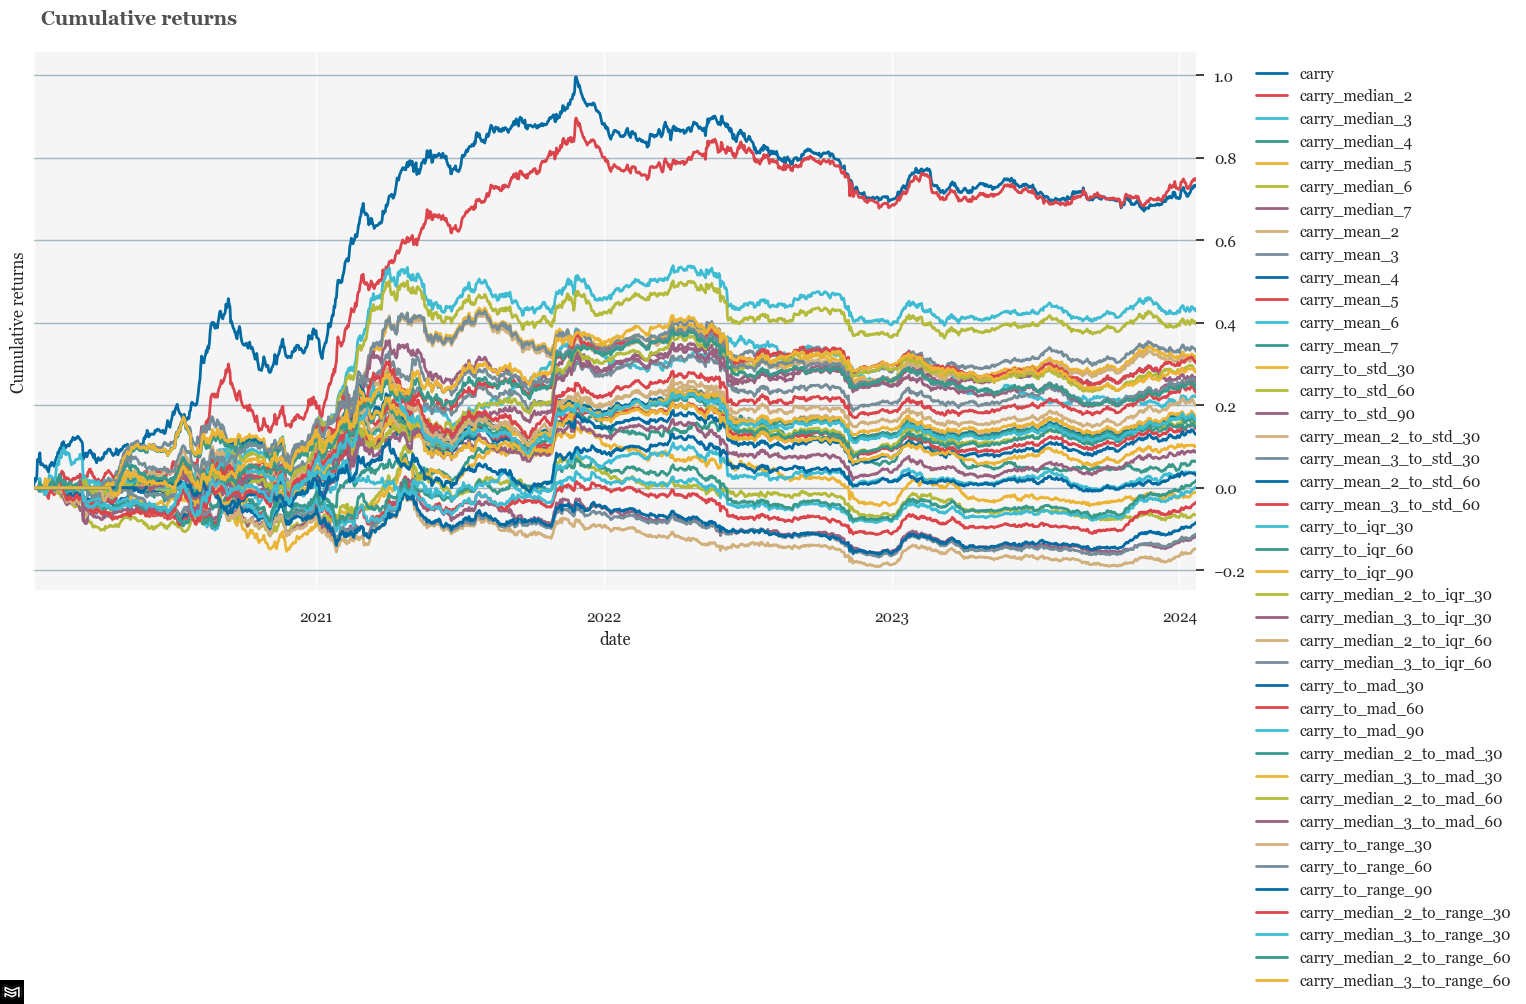

In [201]:
Performance(carry_cs_ret, mkt_ret=mkt_ret, ret_type='log', window_type='expanding').plot_metric()

In [202]:
carry_cs_perf_table.mean()

Cumulative return    0.3170
Annual return        0.0735
Annual volatility    0.0860
Skewness            -0.1380
Kurtosis             8.7295
Max drawdown        -0.1195
VaR                 -0.0100
Tail ratio           1.1605
Sharpe ratio         0.8170
Sortino ratio        1.1390
Calmar ratio         0.6210
Omega ratio          1.1365
Stability            0.5030
Annual alpha         0.0730
Alpha p-val          0.1445
Beta                 0.0200
Beta p-val           0.0000
dtype: float64

### Dual Strategies
Dual strategies (e.g. dual momentum) go long/short assets with factors that are high/low in both the cross section (relative to other assets) and in the time series (relative to the asset's own history). Dual strategies can enhance risk-adjusted returns by combining both time series and cross sectional strategies.

In [164]:
# dual trend returns
carry_dual_ret = Factor(carry_df, ret_df.tr, strategy='dual_ls', factor_bins=3).returns(signal_type='signal_quantiles', rebal_freq=7, t_cost=0.0025, weighting='ew')

In [165]:
carry_dual_perf_table = Performance(carry_dual_ret, mkt_ret=mkt_ret, ret_type='log').table(metrics='all', rank_on='Sharpe ratio')

In [166]:
carry_dual_perf_table

,Cumulative return,Annual return,Annual volatility,Skewness,Kurtosis,Max drawdown,VaR,Tail ratio,Sharpe ratio,Sortino ratio,Calmar ratio,Omega ratio,Stability,Annual alpha,Alpha p-val,Beta,Beta p-val
carry_median_3_to_range_60,0.82,0.17,0.25,1.54,31.60,-0.27,-0.02,1.08,0.63,0.88,0.64,1.11,0.91,0.18,0.20,-0.06,0.00
carry_median_2_to_range_60,0.64,0.14,0.25,1.42,31.25,-0.26,-0.02,1.02,0.52,0.73,0.55,1.09,0.88,0.14,0.29,-0.06,0.00
carry_median_3_to_range_30,0.52,0.12,0.25,1.67,38.12,-0.26,-0.02,0.96,0.44,0.60,0.45,1.08,0.76,0.12,0.36,-0.04,0.00
carry_to_range_60,0.47,0.11,0.24,0.35,18.29,-0.25,-0.02,1.03,0.43,0.57,0.43,1.07,0.80,0.11,0.39,-0.04,0.00
carry_median_3_to_mad_60,0.49,0.12,0.27,1.75,37.44,-0.28,-0.02,0.99,0.41,0.57,0.41,1.07,0.81,0.12,0.43,-0.04,0.00
carry_to_range_30,0.47,0.11,0.25,1.14,26.14,-0.30,-0.02,0.94,0.39,0.53,0.36,1.07,0.64,0.11,0.41,-0.03,0.00
carry_median_2_to_range_30,0.41,0.09,0.25,1.16,29.49,-0.29,-0.02,0.94,0.36,0.48,0.33,1.06,0.67,0.10,0.44,-0.04,0.00
carry_to_range_90,0.41,0.10,0.27,1.08,22.73,-0.30,-0.02,1.03,0.35,0.48,0.33,1.06,0.74,0.10,0.49,-0.05,0.00
carry_median_2_to_mad_60,0.38,0.09,0.26,1.05,26.59,-0.28,-0.02,0.98,0.34,0.46,0.33,1.06,0.76,0.09,0.51,-0.03,0.00
carry_median_3_to_iqr_30,0.39,0.09,0.28,-2.97,55.94,-0.29,-0.02,1.12,0.30,0.33,0.30,1.06,0.80,0.09,0.54,0.04,0.00


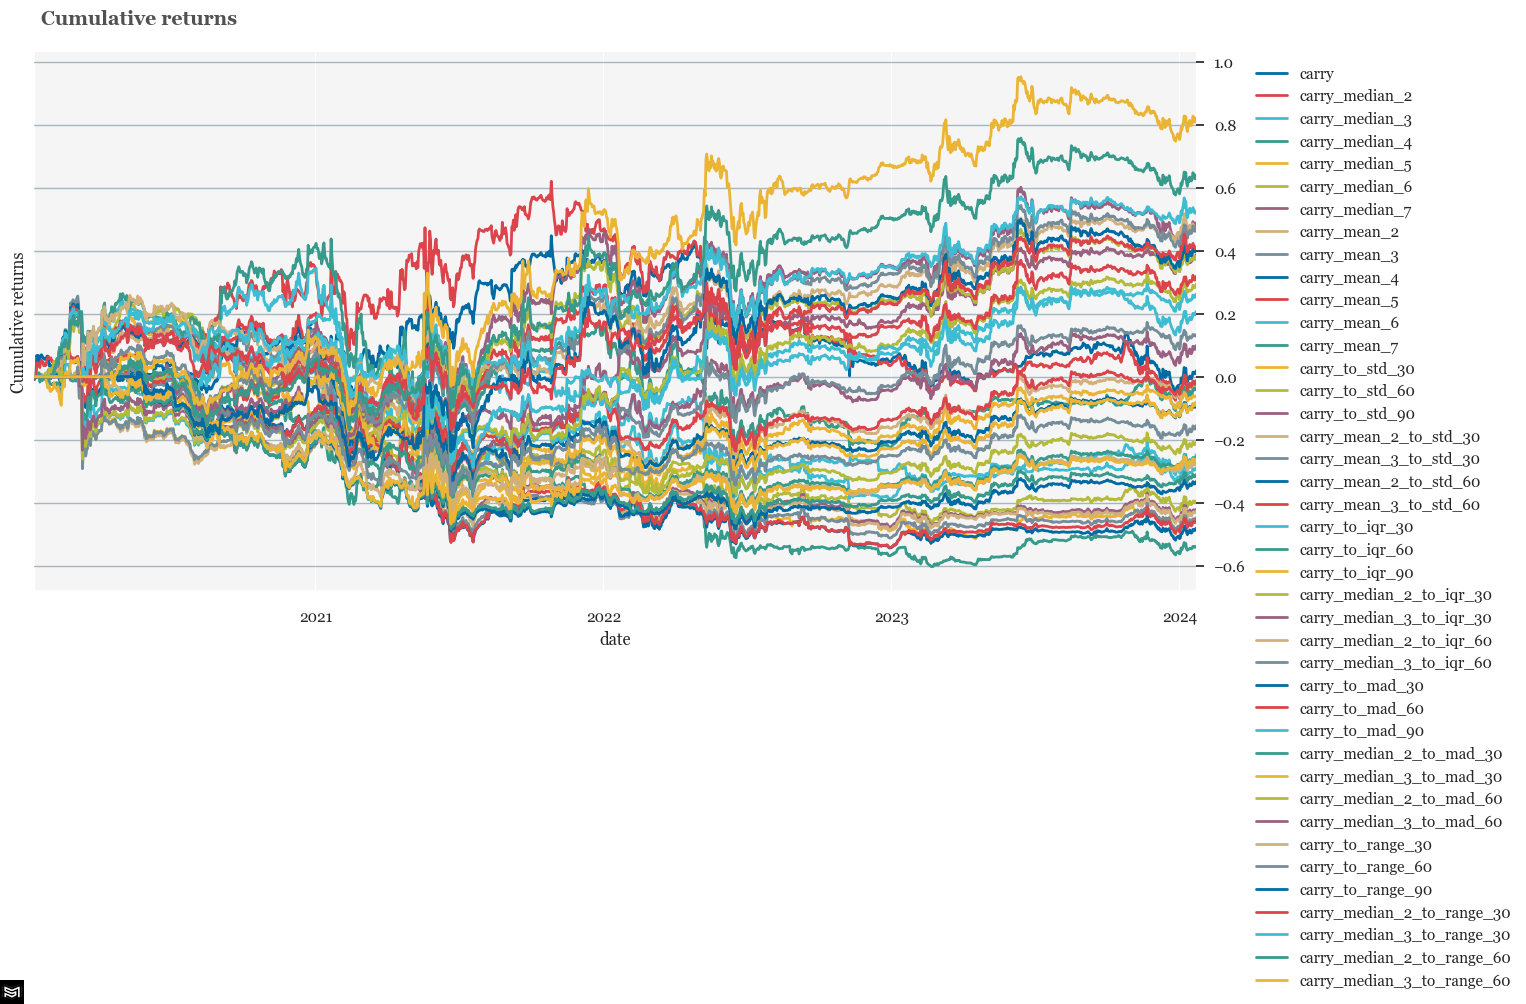

In [167]:
Performance(carry_dual_ret, mkt_ret=mkt_ret, ret_type='log', window_type='expanding').plot_metric()

In [168]:
carry_dual_perf_table.mean()

Cumulative return     0.002195
Annual return        -0.009756
Annual volatility     0.266098
Skewness             -0.504878
Kurtosis             24.354146
Max drawdown         -0.415854
VaR                  -0.020000
Tail ratio            0.973902
Sharpe ratio         -0.050488
Sortino ratio        -0.051707
Calmar ratio          0.039756
Omega ratio           0.993902
Stability             0.539024
Annual alpha         -0.008780
Alpha p-val           0.561707
Beta                  0.007317
Beta p-val            0.091220
dtype: float64

## Quantile Returns
Factor quantile returns provide a measure of alpha factor performance. 

We can use the ```quantiles``` method to analyze returns across bins/quantiles in order to assess the robustness of the alpha factor. Returns which increase monotonically with quantiles are likely to be more reliable that those with positive but non-monotonic relationships.

- The `factor` parameter in the quantile method allows us to select the factor for which to create quantiles. 
- The `metric` parameter allows us to compute a specific metrics from the ```Performance``` class. Here we use the default 'ret' value for returns.
- The ```rebal_freq``` parameter allows us to modify the rebalancing frequency for the strategy. This value defaults to 1, meaning changing with each period/frequency. We select '7' for weekly rebalancing with daily data frequency.

### Time Series Strategy

In [169]:
carry_ts_quantile_ret = Factor(carry_df, ret_df.tr, strategy='ts_ls', factor_bins=3).quantiles(factor=carry_ts_perf_table.iloc[0].name, metric='ret', rebal_freq=7)

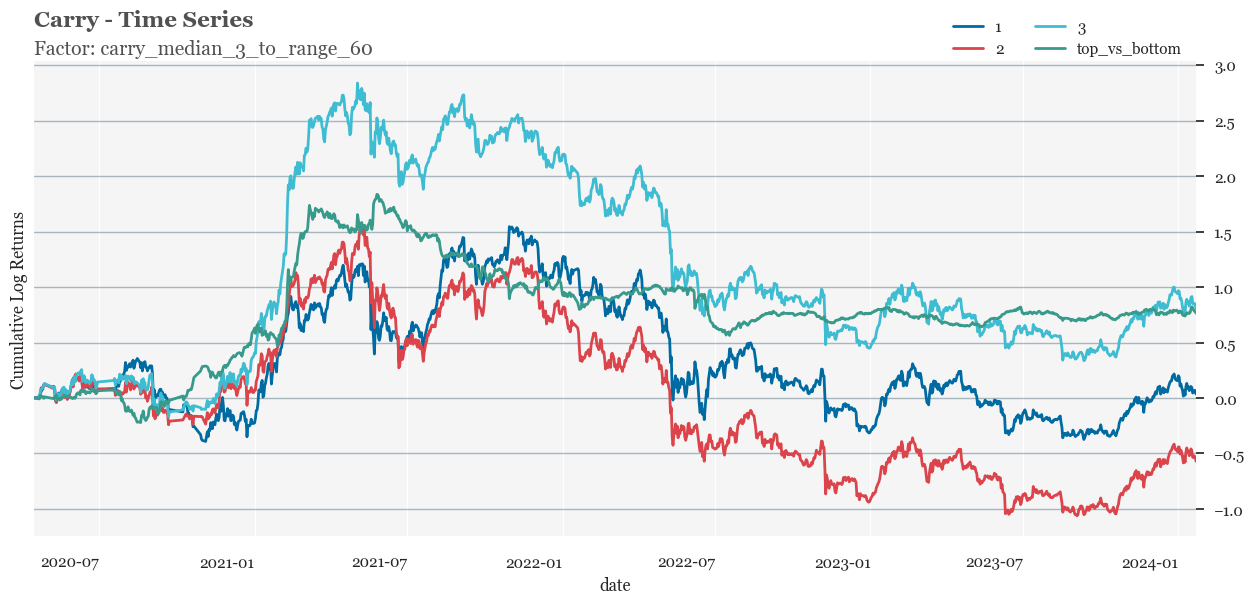

In [170]:
plot_series(carry_ts_quantile_ret.cumsum(),
            title="Carry - Time Series",
            subtitle=f"Factor: {carry_ts_perf_table.iloc[0].name}",
            y_label='Cumulative Log Returns'
           )

In [171]:
carry_ts_quantile_ann_ret = Factor(carry_df, ret_df.tr, strategy='ts_ls', factor_bins=3).quantiles(factor=carry_ts_perf_table.iloc[0].name, metric='ann_ret')

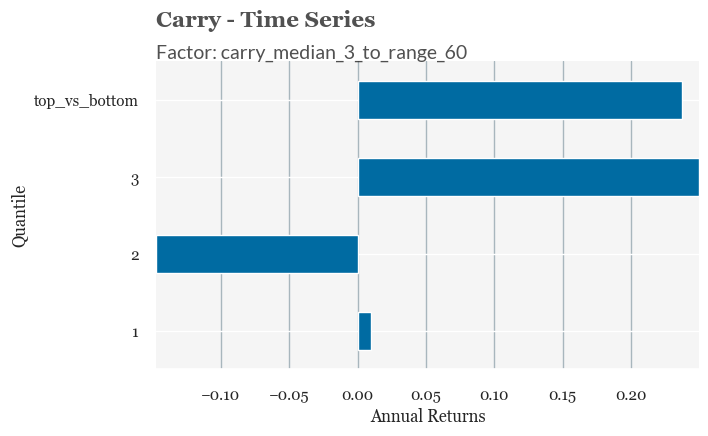

In [172]:
plot_bar(carry_ts_quantile_ann_ret,
         axis='horizontal',
         title="Carry - Time Series",
         subtitle=f"Factor: {carry_ts_perf_table.iloc[0].name}",
         y_label='Quantile',
         x_label='Annual Returns'
         )

In [173]:
carry_ts_quantile_vol = Factor(carry_df, ret_df.tr, strategy='ts_ls', factor_bins=3).quantiles(factor=carry_ts_perf_table.iloc[0].name, metric='ann_vol')

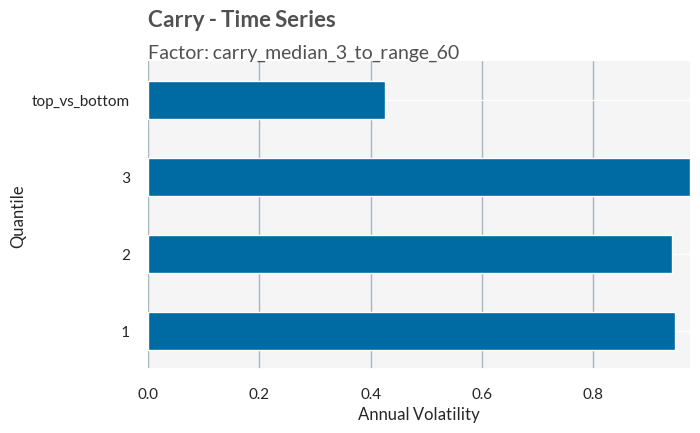

In [174]:
plot_bar(carry_ts_quantile_vol,
         axis='horizontal',
         title="Carry - Time Series",
         subtitle=f"Factor: {carry_ts_perf_table.iloc[0].name}",
         y_label='Quantile',
         x_label='Annual Volatility'
         )

In [175]:
carry_ts_quantile_sr = Factor(carry_df, ret_df.tr, strategy='ts_ls', factor_bins=3).quantiles(factor=carry_ts_perf_table.iloc[0].name, metric='sharpe_ratio')

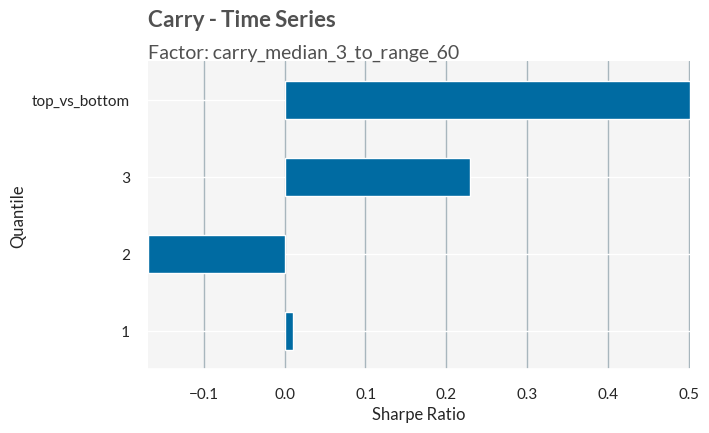

In [176]:
plot_bar(carry_ts_quantile_sr,
         axis='horizontal',
         title="Carry - Time Series",
         subtitle=f"Factor: {carry_ts_perf_table.iloc[0].name}",
         y_label='Quantile',
         x_label='Sharpe Ratio'
         )

### Cross-sectional Strategy

In [177]:
carry_cs_quantile_ret = Factor(carry_df, ret_df.tr, strategy='cs_ls', factor_bins=5).quantiles(factor=carry_cs_perf_table.iloc[0].name, metric='ret')

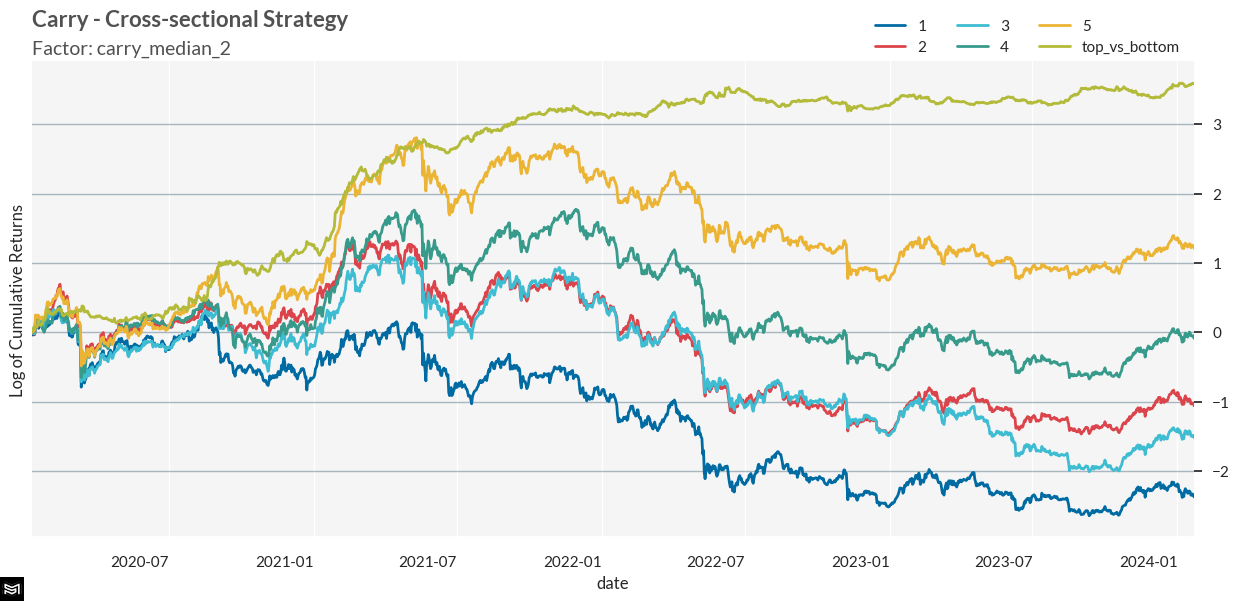

In [178]:
plot_series(carry_cs_quantile_ret.cumsum(),
            title="Carry - Cross-sectional Strategy",
            subtitle=f"Factor: {carry_cs_perf_table.iloc[0].name}",
            y_label='Log of Cumulative Returns',
            add_logo=True
           )

In [179]:
carry_cs_quantile_ann_ret = Factor(carry_df, ret_df.tr, strategy='cs_ls', factor_bins=5).quantiles(factor=carry_cs_perf_table.iloc[0].name, metric='ann_ret')

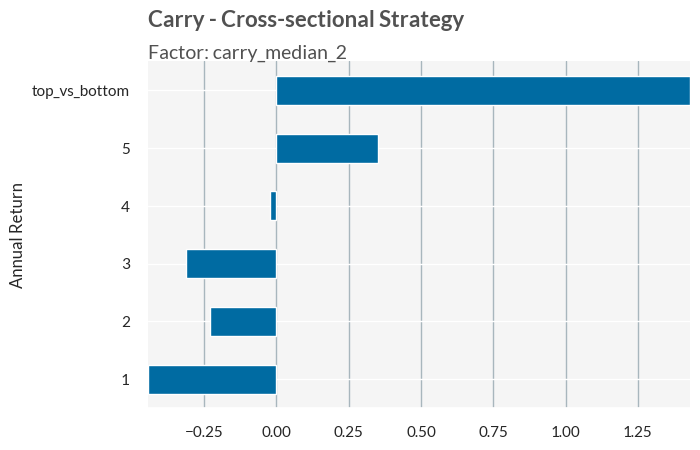

In [180]:
plot_bar(carry_cs_quantile_ann_ret,
         axis='horizontal',
         title="Carry - Cross-sectional Strategy",
         subtitle=f"Factor: {carry_cs_perf_table.iloc[0].name}",
         y_label='Annual Return'
        )

In [181]:
carry_cs_quantile_ann_vol = Factor(carry_df, ret_df.tr, strategy='cs_ls', factor_bins=5).quantiles(factor=carry_cs_perf_table.iloc[0].name, metric='ann_vol')

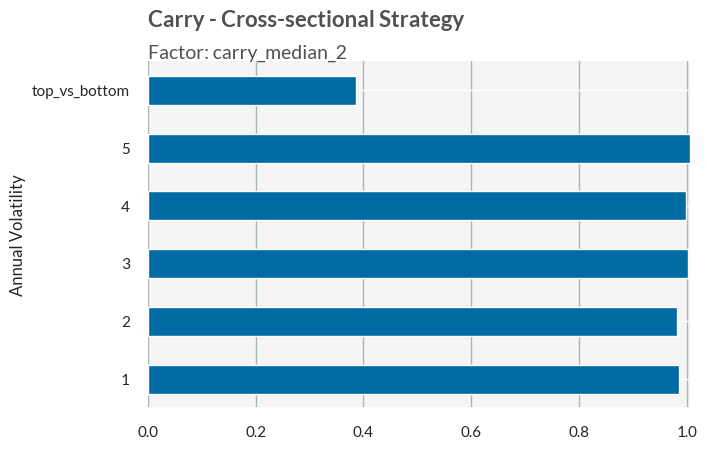

In [182]:
plot_bar(carry_cs_quantile_ann_vol,
         axis='horizontal',
         title="Carry - Cross-sectional Strategy",
         subtitle=f"Factor: {carry_cs_perf_table.iloc[0].name}",
         y_label='Annual Volatility'
        )

In [183]:
carry_cs_quantile_sr = Factor(carry_df, ret_df.tr, strategy='cs_ls', factor_bins=5).quantiles(factor=carry_cs_perf_table.iloc[0].name, metric='sharpe_ratio')

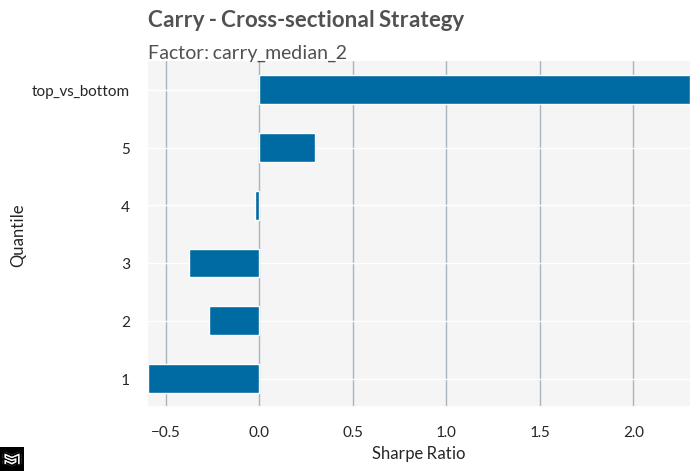

In [184]:
plot_bar(carry_cs_quantile_sr,
         axis='horizontal',
         title="Carry - Cross-sectional Strategy",
         subtitle=f"Factor: {carry_cs_perf_table.iloc[0].name}",
         y_label='Quantile',
         x_label='Sharpe Ratio',
         add_logo=True
         )

## Carry Dashboard

In [ ]:
carry_

In [187]:
carry_signals_bar = carry_df.carry.unstack().iloc[-1].sort_values().dropna()

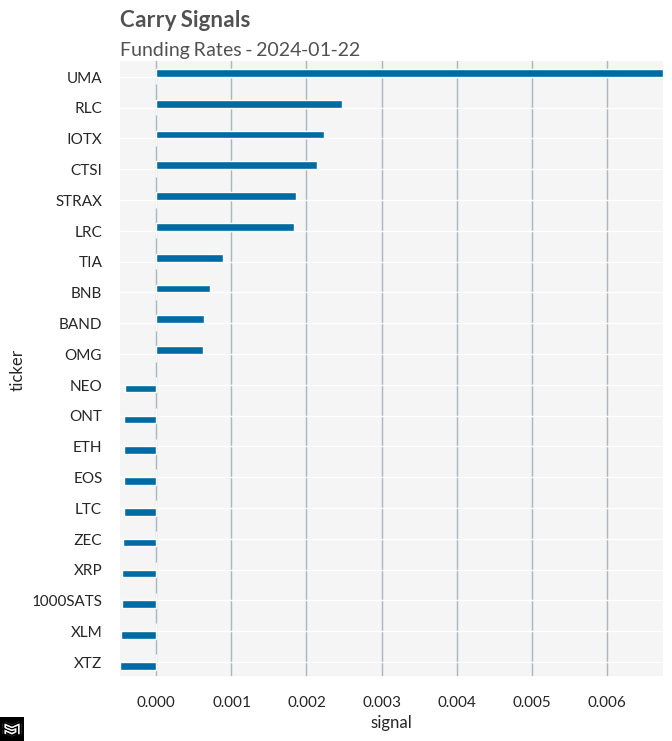

In [188]:
plot_bar(pd.concat([carry_signals_bar[:10], carry_signals_bar[-10:]], axis=1), 
         title="Carry Signals",
         subtitle=f"Funding Rates - {carry_df.iloc[-1].name[0].date()}",
         axis='horizontal', 
         y_label='ticker', 
         x_label='signal', 
         add_logo=True,
        )